In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загрузка данных
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
submission_df = pd.read_csv('sample_submission.csv')

# Предполагается, что целевая переменная (SalePrice) известна для валидационного набора в submission_df
val_sale_price = submission_df['SalePrice']

# Удаление столбца ID если он есть
train_ids = train_df.pop('Id')
val_ids = val_df.pop('Id')

# Разделение данных на признаки и целевую переменную
X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']
X_val = val_df

# Определение числовых и категориальных столбцов
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Создание пайплайна для предобработки данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Преобразование данных
X_train = preprocessor.fit_transform(X_train).toarray()
X_val = preprocessor.transform(X_val).toarray()

# Преобразование целевой переменной
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Создание Dataset и DataLoader
class HousePriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HousePriceDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



In [7]:
# Определение модели
class HousePricePredictor(nn.Module):
    def __init__(self, input_dim):
        super(HousePricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = X_train.shape[1]
model = HousePricePredictor(input_dim).to(device)

In [8]:
# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Обучение модели
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs).flatten()
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

Epoch [10/200], Train Loss: 0.0349
Epoch [20/200], Train Loss: 0.0143
Epoch [30/200], Train Loss: 0.0073
Epoch [40/200], Train Loss: 0.0053
Epoch [50/200], Train Loss: 0.0038
Epoch [60/200], Train Loss: 0.0025
Epoch [70/200], Train Loss: 0.0054
Epoch [80/200], Train Loss: 0.0015
Epoch [90/200], Train Loss: 0.0043
Epoch [100/200], Train Loss: 0.0069
Epoch [110/200], Train Loss: 0.0007
Epoch [120/200], Train Loss: 0.0007
Epoch [130/200], Train Loss: 0.0028
Epoch [140/200], Train Loss: 0.0015
Epoch [150/200], Train Loss: 0.0037
Epoch [160/200], Train Loss: 0.0011
Epoch [170/200], Train Loss: 0.0010
Epoch [180/200], Train Loss: 0.0013
Epoch [190/200], Train Loss: 0.0010
Epoch [200/200], Train Loss: 0.0048


In [10]:
# Предсказание и оценка модели
model.eval()
with torch.no_grad():
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_pred = model(X_val_tensor).flatten().cpu().numpy()

    # Обратное преобразование нормализации
    y_pred_denorm = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true_denorm = val_sale_price.values

    # Подсчет MSE
    mse = mean_squared_error(y_true_denorm, y_pred_denorm)
    print(f'Test MSE: {mse:.4f}')

Test MSE: 5646705978.4321


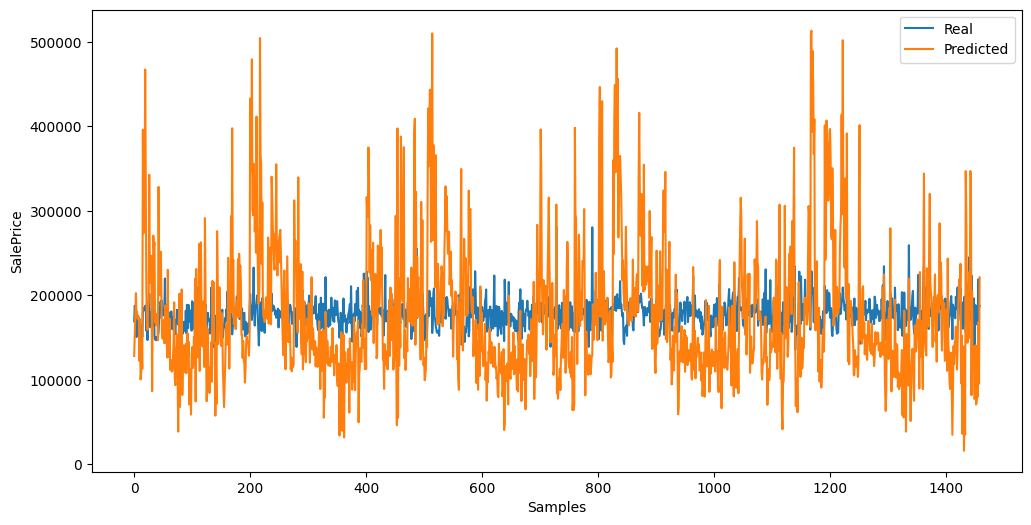

In [11]:
# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_true_denorm)), y_true_denorm, label='Real')
plt.plot(np.arange(len(y_pred_denorm)), y_pred_denorm, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('SalePrice')
plt.legend()
plt.show()